<a href="https://colab.research.google.com/github/rampopat/uncertainty/blob/main/Uncertainty_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uncertainty Investigation

This notebook contains the uncertainty analysis for both datasets. The majority concerns the DementiaBank dataset and the last section is for the MIMIC dataset.

The notebook is organised into a markdown section hierarchy and the sections are named informatively. Broadly we have the imports and core functions. We then consider uncertain transcripts. We import the Bayesian Deep Learning models' predictions and then we conduct several uncertainty analyses. Firstly, we look at uncertainty based on ranking, roc curves, calibration, the main uncertainty analysis and high level analysis. We then look at the relationships between probabilities and uncertainties. We then conduct a quantile analysis. Finally, we have the MIMIC referral learning multiple labels analysis and plots. 

Here is the Table of Contents.

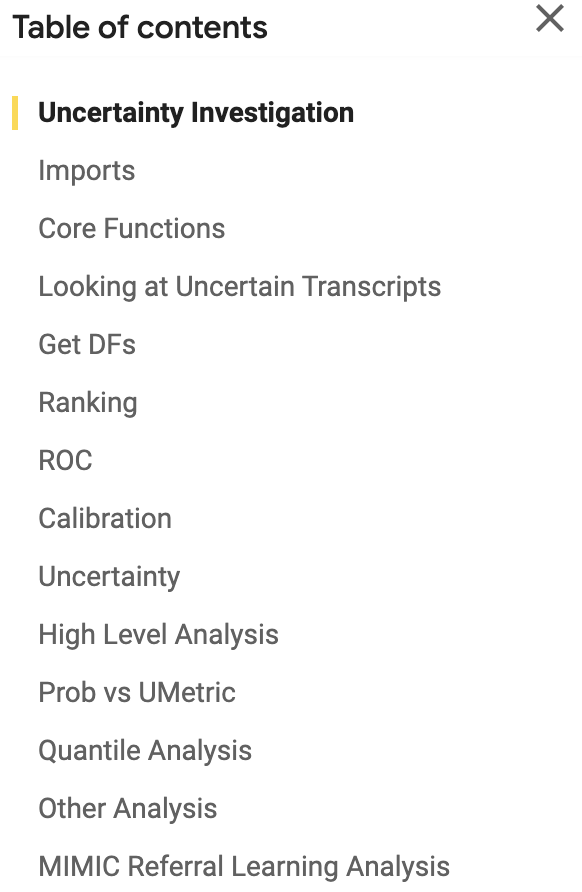

# Imports

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, roc_curve, plot_roc_curve, plot_confusion_matrix
import sklearn.metrics
from scipy.stats import entropy

In [ ]:
import seaborn as sns
sns.set_style('whitegrid')

In [ ]:
!pip install netcal
import netcal as nc

In [ ]:
import warnings
import sklearn
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

In [ ]:
from netcal.scaling import TemperatureScaling
from netcal.metrics import ECE
from netcal.presentation import ReliabilityDiagram

In [ ]:
from scipy.ndimage.filters import gaussian_filter1d

In [ ]:
%load_ext google.colab.data_table

In [ ]:
%config InlineBackend.figure_format = 'retina'

In [ ]:
!unzip drive/MyDrive/UncertaintyAnalysisData.zip

# Core Functions

In [ ]:
DPI=400

In [ ]:
def ece(y_true, y_pred, bins=30):
    # This is a pmetric because we want to calculate this on portions of data rather than order data by it
    # Use same function signature as the other pmetrics to allow usage
    ece = ECE(bins)
    return 1 - ece.measure(y_pred, y_true)

def ece_ts(y_true, y_pred, bins=30):
    # This is a pmetric because we want to calculate this on portions of data rather than order data by it
    # Use same function signature as the other pmetrics to allow usage
    temperature = TemperatureScaling()
    temperature.fit(y_pred, y_true)
    calibrated = temperature.transform(y_pred)
    ece = ECE(bins)
    return 1 - ece.measure(calibrated, y_true)

UMETRICS = ['entropy', 'exp_entropy', 'mutual_info', 'vr']
# UMETRIC_NAMES = ['Predictive Entropy','Expected Entropy', 'Mutual Information', 'Variation Ratio']
UMETRIC_NAMES = ['PE','EE', 'MI', 'VR']
PMETRIC_FNS = [accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, ece]
PMETRIC_NAMES = ['Accuracy', 'F1', 'ROC AUC', 'Precision', 'Recall', '1-ECE'] 
PATH = 'UncertaintyAnalysisData/'    

In [ ]:
def get_entropy(ps):
    # ps is df series of the preds 
    # entropy(p) = -((1-p)log_2(1-p) + plog_2(p)) for p scalar,
    # we map this over the vector of probabilities
    return entropy(pk=np.stack([1-ps, ps]), base=2, axis=0)
def get_kld(all_preds):
    # Disagreement metric in footnote 9 of Deep Ensembles Paper
    # We scale their metric because they do sum which doesn't allow for comparison of 
    # ensembles of different size so we do mean

    # all_preds.shape = (M, data_size)
    ensemble_size = all_preds.shape[0]
    data_size = all_preds.shape[1]
    mean_preds = all_preds.mean(axis=0)
    result = np.zeros(data_size)
    for m in range(ensemble_size):
        ps = all_preds[m]
        result += entropy(pk=np.stack([ps, 1-ps]), qk=[mean_preds, 1-mean_preds], base=2, axis=0)

    return result / ensemble_size

def get_expected_entropy(all_preds):
    # all_preds.shape = (M = ensemble_size, data_size)
    ensemble_size = all_preds.shape[0]
    individual_entrops = np.array([get_entropy(all_preds[m]) for m in range(ensemble_size)])
    return individual_entrops.mean(axis=0)

def get_mutual_info(all_preds):
    # all_preds.shape = (M, data_size)
    # predictive_entropy.shape = (data_size,)
    predictive_entropy = get_entropy(all_preds.mean(axis=0))
    expected_entropy = get_expected_entropy(all_preds)
    return predictive_entropy - expected_entropy

def get_variation_ratio(all_preds, threshold=0.5):
    # all_preds.shape = (M, data_size)
    # ps, mean_preds, vrs shape = (data_size)
    data_size = all_preds.shape[1]
    ps = binarize(all_preds, threshold=threshold).mean(axis=0) # probability of dementia
    mean_preds = binarize(all_preds.mean(axis=0), threshold=threshold)
    vrs = [ps[i] if (mean_preds[i] == 0) else (1 - ps[i]) for i in range(data_size)]
    return vrs

def binarize(ps, threshold=0.5):
    return np.where(ps > threshold, 1, 0)

In [ ]:
def cumul_perf2(metric, true_labels, pred_labels, preds):
    if metric == roc_auc_score:
        return np.array([roc_auc_score(true_labels[:(i + 1)], preds[:(i + 1)]) if true_labels[:(i + 1)].mean() < 1 and true_labels[:(i + 1)].mean() > 0 else 1 for i in range(len(true_labels))])
    if metric == ece or metric == ece_ts:
        return np.array([metric(true_labels[:(i + 1)], preds[:(i + 1)])  for i in range(len(true_labels))])
    return np.array([metric(true_labels[:(i + 1)], pred_labels[:(i + 1)])  for i in range(len(true_labels))])

def cumul_perf(metric, df):
    return cumul_perf2(metric, df.true_label.to_numpy(), df.pred_label.to_numpy(), df.pred.to_numpy())

# idea: define function like cumul_perf that allows us to permute both true and pred label in the same way and then we compute the scores
def cumul_perf_permute(metric, df, num_seeds=100):
    # returns error bar arguments
    controls = []
    for seed in range(num_seeds):
        true_labels = np.random.RandomState(seed=seed).permutation(df.true_label)
        pred_labels = np.random.RandomState(seed=seed).permutation(df.pred_label)
        preds = None
        if metric == roc_auc_score or metric == ece or metric == ece_ts:
            preds = np.random.RandomState(seed=seed).permutation(df.pred)
        controls.append(cumul_perf2(metric, true_labels, pred_labels, preds))
    controls = np.array(controls)
    return controls.mean(axis=0), controls.std(axis=0)

def cumul_perf_ub(metric, df):
    # returns upper limit 
    # ascending False because being incorrect = higher uncertainty
    df = df.sort_values(by='correct', ascending=False)
    return cumul_perf(metric, df)

def get_pmetrics(df, sort_by=None, pmetrics=PMETRIC_FNS):
    if sort_by:
        df = df.sort_values(by=sort_by, ascending=True)
    return tuple(cumul_perf(pmetric, df) for pmetric in pmetrics)

In [ ]:
def get_df(name1, name2):    
    df = pd.read_pickle(PATH + name1).sort_index()
    all_preds = pd.read_pickle(PATH + name2).to_numpy()
    df['entropy'] = get_entropy(df['pred'])
    df['neg_halfway_diff'] = -abs(0.5 - df['pred'])    
    df['mutual_info'] = get_mutual_info(all_preds)
    df['kld_disagreement'] = get_kld(all_preds)
    df['exp_entropy'] = get_expected_entropy(all_preds)
    df['vr'] = get_variation_ratio(all_preds)
    return df, all_preds

In [ ]:
def get_df_from_preds(all_preds=None, name=None, labels=None, threshold=0.5):
    if all_preds is None:
        all_preds = pd.read_pickle(PATH + name).to_numpy()    
    # all_preds.shape = (ensemble_size, data_size)
    preds = all_preds.mean(axis=0)
    pred_var = all_preds.var(axis=0)
    df = pd.DataFrame(list(zip(list(pred_var), list(preds))), columns=['pred_var', 'pred'])
    df['pred_label'] = binarize(preds, threshold=threshold)
    df['true_label'] = labels
    df['correct'] = df['pred_label'] == df['true_label']
    df = df.astype({'correct': int })
    df['entropy'] = get_entropy(df['pred'])
    df['neg_halfway_diff'] = -abs(0.5 - preds)    
    df['mutual_info'] = get_mutual_info(all_preds)
    df['kld_disagreement'] = get_kld(all_preds)
    df['exp_entropy'] = get_expected_entropy(all_preds)
    df['vr'] = get_variation_ratio(all_preds, threshold=threshold)
    return df, all_preds

def get_df_single_model(preds=None, labels=None, name=None, threshold=0.5):
    if name is not None:
        preds = pd.read_pickle(PATH + name).to_numpy()
    
    if len(preds.shape) > 1:
        preds = np.squeeze(preds)        
    pred_labels = binarize(preds, threshold=threshold)
    df = pd.DataFrame(list(zip(list(preds), list(pred_labels), list(labels))), 
                      columns=['pred', 'pred_label', 'true_label'])
    df['correct'] = df['pred_label'] == df['true_label']
    df = df.astype({'correct': int })
    df['entropy'] = get_entropy(df['pred'])
    return df

In [ ]:
# all_preds = pd.read_pickle(PATH + 'rnnens10ap.pkl').to_numpy()

# Looking at Uncertain Transcripts

In [ ]:
! unzip drive/MyDrive/Pitt.zip

In [ ]:
%%capture
!pip install pylangacq
import pylangacq as pl
import re
import os

In [ ]:
def get_chat_files_labels():
    #  Read ordered chat files from txt file into a list
    with open("drive/MyDrive/ChatFilesList.txt", "r") as cfl:
        lines = cfl.readlines()
    chat_files = [re.sub('\n', '', line) for line in lines]

    #  Extract series of values corresponding to dementia or not based one which folder the transcript comes from
    #  i.e. 1 for Dementia, 0 for HC
    labels = []
    for file in chat_files:
        label = 0
        if 'Dementia' in file:
            label = 1
        labels.append(label)

    def print_missing_files():
        # Should print nothing
        for file in chat_files:
            if not os.path.isfile(file):
                print(file)

    return chat_files, labels

chat_files, full_labels = get_chat_files_labels()

In [ ]:
dementia = pl.Reader.from_files(chat_files)
df = df_rnn 
transcripts = [dementia[idx].words('PAR') for idx in range(dementia.n_files())]
transcripts = list(map(lambda x: " ".join(x), transcripts))
for x in df_rnn.sort_values(by='pred_var').index[:25]:
    print(transcripts[x], full_labels[x], df.pred[x])
for x in df_rnn.sort_values(by='pred_var').index[-25:]:
    print(transcripts[x], full_labels[x], df.pred[x])

# Get DFs

In [ ]:
DPI=400

In [ ]:
preds_rnn_mc = np.load(PATH + 'rnnmc.npy')
labels = get_df('rnnens10.pkl', 'rnnens10ap.pkl')[0].true_label
df_rnn_mc, preds_rnn_mc = get_df_from_preds(all_preds=np.load(PATH + 'rnnmc.npy'), labels=labels)
df_rnn, preds_rnn = get_df_from_preds(name='rnnens10ap.pkl', labels=labels)
df_brnns, preds_brnns = get_df_from_preds(name='brnnens5ap.pkl', labels=labels)
df_brnn, preds_brnn = get_df_from_preds(name='brnnap.pkl', labels=labels)
df_trf, preds_trf = get_df_from_preds(name='troberta5ap.pkl', labels=labels)
df_strf, preds_strf = get_df_from_preds(name='sroberta5ap.pkl', labels=labels)
df_trf_mc, preds_trf_mc = get_df_from_preds(name='trobertamcseed3.pkl', labels=labels)

some_dfs = [df_rnn, df_brnn, df_brnns, df_trf]
SOME_DF_NAMES = ['RNN-ENS', 'BRNN', 'BRNN-ENS', 'T-TRF-ENS']

dfs = [df_rnn_mc, df_rnn, df_brnn, df_brnns, df_trf_mc, df_trf, df_strf]
DF_NAMES = ['RNN-MC', 'RNN-ENS', 'BRNN', 'BRNN-ENS', 'T-TRF-MC', 'T-TRF-ENS', 'S-TRF-ENS']

preds_ens = [preds_rnn, preds_brnns, preds_trf, preds_strf]
dfs_ens = [df_rnn, df_brnns, df_trf, df_strf]
DF_NAMES_ENS = ['RNN-ENS', 'BRNN-ENS', 'T-TRF-ENS', 'S-TRF-ENS']

main_preds = [preds_rnn, preds_brnn, preds_brnns, preds_trf]
main_dfs = [df_rnn, df_brnn, df_brnns, df_trf]
MAIN_DF_NAMES = ['RNN-ENS', 'BRNN', 'BRNN-ENS', 'T-TRF-ENS']

In [ ]:
mis = []
for i, df in enumerate(dfs_ens):
    print(DF_NAMES_ENS[i], df.mutual_info.mean(), df.vr.mean())

In [ ]:
for i, df in enumerate(dfs_ens):
    print(DF_NAMES_ENS[i], len(df[df.vr != 0])/len(df))

# Ranking

In [ ]:
from scipy.stats import pearsonr
print(pearsonr(df_rnn.pred_var, df_rnn.mutual_info))
print(pearsonr(df_trf.pred_var, df_trf.mutual_info))
print(pearsonr(df_brnn.pred_var, df_brnn.mutual_info))
print(pearsonr(df_brnns.pred_var, df_brnns.mutual_info))
print(pearsonr(df_rnn.entropy, df_rnn.mutual_info))
print(pearsonr(df_trf.entropy, df_trf.mutual_info))
print(pearsonr(df_brnn.entropy, df_brnn.mutual_info))
print(pearsonr(df_brnns.entropy, df_brnns.mutual_info))
print(pearsonr(df_rnn.entropy, df_rnn.exp_entropy))
print(pearsonr(df_trf.entropy, df_trf.exp_entropy))
print(pearsonr(df_brnn.entropy, df_brnn.exp_entropy))
print(pearsonr(df_brnns.entropy, df_brnns.exp_entropy))
# Basically pred var and mutual info are the same

In [ ]:
sns.pairplot(df_rnn[['entropy', 'mutual_info', 'exp_entropy', 'vr']])

In [ ]:
def umetric_comparison(df, sort_by='mutual_info', title=''):
    dfx = df.copy()
    dfx = dfx.sort_values(by=sort_by)
    plt.figure(figsize=(5, 5))
    # plt.scatter(np.arange(len(dfx)), dfx.pred_var, marker='.', label='Pred Var') # * dfx.mutual_info.median()/dfx.pred_var.median(), marker='.')
    plt.scatter(np.arange(len(dfx)), dfx.mutual_info, label='Mutual Info', marker='.')
    plt.scatter(np.arange(len(dfx)), dfx.exp_entropy, marker='.', label='Exp Entropy') # * 
    plt.scatter(np.arange(len(dfx)), dfx.entropy, marker='.', label='Entropy')
    plt.scatter(np.arange(len(dfx)), dfx.vr,label='Var Ratio', marker='.')
    plt.xlabel('Patient ID - Ordered By Mutual Info')
    plt.title(title)
    plt.tight_layout()
    plt.savefig('')
    plt.legend()
    plt.show()
# plt.scatter(np.arange(len(dfx)), dfx.vr * dfx.mutual_info.median()/dfx.vr.median(), marker='.')
# plt.scatter(np.arange(len(dfx)), dfx.entropy * dfx.mutual_info.median()/dfx.entropy.median(), marker='.')

In [ ]:
def umetric_comparison_wrtmi(df):
    dfx = df.copy()
    plt.figure(figsize=(5, 5))
    plt.scatter(dfx.mutual_info, dfx.exp_entropy, label='Exp Entropy', marker='.')
    plt.scatter(dfx.mutual_info, dfx.entropy, label='Entropy', marker='.')
    # plt.scatter(dfx.mutual_info, dfx.pred_var,label='Pred Var', marker='.')
    plt.scatter(dfx.mutual_info, dfx.vr,label='Var Ratio', marker='.')
    plt.xlabel('Mutual Info')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('umetric-relationships', dpi=DPI)
    plt.show()

In [ ]:
def umetric_comparison_subplots(dfs, sort_by='mutual_info'):
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
    fig.delaxes(axes[2][2])
    fig.delaxes(axes[2][1])
    plt.rcParams.update({'font.size': 16})
    for i, df in enumerate(dfs):
        dfx = df.copy()
        dfx = dfx.sort_values(by=sort_by)
        # plt.figure(figsize=(5, 5))
        # plt.scatter(np.arange(len(dfx)), dfx.pred_var, marker='.', label='Pred Var') # * dfx.mutual_info.median()/dfx.pred_var.median(), marker='.')
        plt.subplot(3, 3, i + 1)
        plt.scatter(np.arange(len(dfx)), dfx.exp_entropy, marker='.', label='EE') # * 
        plt.scatter(np.arange(len(dfx)), dfx.entropy, marker='.', label='PE')
        plt.scatter(np.arange(len(dfx)), dfx.mutual_info, label='MI', marker='.')
        plt.scatter(np.arange(len(dfx)), dfx.vr,label='VR', marker='.')
        plt.xlabel('Patient ID Ordered By PE') #  - Ordered By ' + sort_by)
        plt.title(DF_NAMES[i])
        plt.legend(loc='upper left')
    # plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('umetrics-comparisons', dpi=DPI)
    plt.show()

In [ ]:
umetric_comparison_subplots(dfs, sort_by='entropy')

In [ ]:
plt.subplots(nrows=7, ncols=4, figsize=(20, 35))
idx = 1
for i, df in enumerate(dfs):
    for j, umetric in enumerate(UMETRICS):
        plt.subplot(7, 4, idx)
        plt.title(DF_NAMES[i] + ' ' + UMETRIC_NAMES[j])
        plt.hist(df[umetric], density=True)
        idx += 1
plt.show()

In [ ]:
correlations = np.zeros((len(dfs), 6))
for i, df in enumerate(dfs):
    print(DF_NAMES[i])
    z = 0
    for j, umetric in enumerate(UMETRICS):
        for k, umetric2 in enumerate(UMETRICS):
            if k <= j:
                continue
            corr = pearsonr(df[umetric], df[umetric2])[0]
            print(UMETRICS[j], UMETRICS[k], corr)
            correlations[i, z] = corr
            z += 1

In [ ]:
correlations

In [ ]:
corr_df = pd.DataFrame(correlations, columns=['PE MI', 'PE EE', 'PE VR', 'MI EE', 'MI VR', 'EE VR'])
corr_df.index = DF_NAMES
print(corr_df.round(2).to_latex())

In [ ]:
for i, df in enumerate(dfs):
    umetric_comparison(df, sort_by='mutual_info', title=DF_NAMES[i])

In [ ]:
dfx = df_brnn.copy()
plt.figure(figsize=(5, 5))
plt.scatter(dfx.mutual_info, dfx.exp_entropy, marker='.')
plt.scatter(dfx.mutual_info, dfx.entropy, marker='.')
plt.xlabel('Mutual Info')
plt.ylabel('Exp Entropy')
# plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
plt.scatter(np.arange(len(dfx)), dfx.vr, marker='.')

In [ ]:
plt.scatter(np.arange(len(dfx)), dfx.vr * dfx.mutual_info.median()/dfx.vr.median(), marker='.')
plt.scatter(np.arange(len(dfx)), dfx.entropy * dfx.mutual_info.median()/dfx.entropy.median(), marker='.')

In [ ]:
dfy = dfx.sort_values(by='entropy')
plt.plot(np.arange(len(dfy)), dfy.entropy)
plt.scatter(np.arange(len(dfy)), dfy.mutual_info, marker='.')
plt.scatter(np.arange(len(dfy)), dfy.exp_entropy, marker='.')

In [ ]:
plt.plot(np.arange(len(dfx)), dfx.mutual_info)

In [ ]:
df_rnn.columns

In [ ]:
df_rand = df_rnn[['pred_var', 'mutual_info', 'correct']].melt(value_vars=['pred_var', 'mutual_info'], var_name='groups', value_name='vals')
df_rand.head(10)

In [ ]:
mapper = dict(zip(UMETRICS, UMETRIC_NAMES))
mapper

In [ ]:
df_rnn2 = df_rnn.rename(columns=mapper).copy()
df_rnn2.head(10)

In [ ]:
UMETRIC_NAMES

In [ ]:
UMETRIC_SHORT_NAMES = ['PE', 'EE', 'MI', 'VR']

In [ ]:
df_trf.mutual_info.mean() / df_trf.pred_var.mean()

In [ ]:
def get_boxen_plot(dfx, name='', rename=False, scale=False):
    df = dfx.copy()
    if scale:
        for umetric in UMETRICS:
            if umetric == 'mutual_info':
                continue                
            scale_factor = df.mutual_info[df.correct==True].median() / df[umetric][df.correct==True].median()
            df[umetric] *= scale_factor
    scaled_str = '' if not scale else '-scaled'
    y_label_scaled = '' if not scale else 'Scaled '
    if rename:
        new_names = UMETRIC_SHORT_NAMES
        mapper = dict(zip(UMETRICS, new_names))        
        df = df.rename(columns=mapper).copy()
        df_true = df[df['correct']==True].melt(value_vars=new_names, var_name='Uncertainty Metric', value_name='Uncertainty')
        df_false = df[df['correct']==False].melt(value_vars=new_names, var_name='Uncertainty Metric', value_name='Uncertainty')
    else:
        df_true = df[df['correct']==True].melt(value_vars=UMETRICS, var_name='Uncertainty Metric', value_name='Uncertainty')
        df_false = df[df['correct']==False].melt(value_vars=UMETRICS, var_name='Uncertainty Metric', value_name='Uncertainty') 
    df_combined = pd.concat([df_true.assign(Classification='Correct'), df_false.assign(Classification='Incorrect')], axis=0)
    # can change kind to be 'box' or 'violin', but violin needs split=True and bw=0.3 as additional parameters
    sns.catplot(x="Uncertainty Metric", y="Uncertainty", data=df_combined, hue='Classification', kind='boxen', legend=False)
    plt.title(name)
    plt.legend(loc='upper right')
    plt.ylabel(y_label_scaled + "Uncertainty")
    file_name = 'boxen-plot-' + name.lower().replace(' ', '').lower() + scaled_str
    print(file_name)
    plt.tight_layout()
    plt.savefig(file_name, dpi=DPI)
    plt.show()

In [ ]:
get_boxen_plot(df_rnn, name='RNN-ENS', rename=True)

In [ ]:
get_boxen_plot(df_trf, name='T-TRF-ENS', rename=True)

In [ ]:
get_boxen_plot(df_brnn, name='BRNN', rename=True)

In [ ]:
get_boxen_plot(df_brnns, name='BRNN-ENS', rename=True)

In [ ]:
df_true = df_rnn[df_rnn['correct']==True].melt(value_vars=UMETRICS, var_name='Uncertainty Metric', value_name='Uncertainty')
df_false = df_rnn[df_rnn['correct']==False].melt(value_vars=UMETRICS, var_name='Uncertainty Metric', value_name='Uncertainty')
df_combined = pd.concat([df_true.assign(Classification='Correct'), df_false.assign(Classification='Incorrect')], axis=0)

# ROC

In [ ]:
def roc_auc(df):
    print(roc_auc_score(df.true_label, df.pred))
for df in dfs:
    roc_auc(df)

In [ ]:
def get_roc_curves():
    def get_roc_curve(df, name=''):
        fpr, tpr, thresholds = roc_curve(df.true_label, df.pred)
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        label = name + ' (AUC = {:.2f})'.format(roc_auc)
        # display = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=None)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.plot(fpr, tpr, label=label) 
        plt.legend()    
    plt.figure(figsize=(5, 5))   
    get_roc_curve(df_rnn, 'RNN')
    get_roc_curve(df_trf, 'Transformer')
    get_roc_curve(df_brnn, 'B-RNN')
    plt.title('ROC Curves')
    plt.tight_layout()
    plt.show() 

In [ ]:
def get_roc_curve(df, name=''):
    plt.figure(figsize=(5, 5))   
    fpr, tpr, thresholds = roc_curve(df.true_label, df.pred)
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    label = name + ' (AUC = {:.2f})'.format(roc_auc)
    # display = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=None)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot(fpr, tpr, label=label) 
    plt.legend() 
    plt.tight_layout()   
    plt.show()

In [ ]:
def get_roc_curve_referred(df, referral_rates, name=''):
    # df is already sorted by some umetric
    # e.g. referral_rates = [0.5, ..., 0.9]
    true_labels = df.true_label.to_numpy()
    preds = df.pred.to_numpy()
    plt.figure(figsize=(9, 5)) 
    for referral_rate in referral_rates:
        num_data_not_referred = int((1 - referral_rate) * len(df))
        ts = true_labels[:num_data_not_referred]
        ps = preds[:num_data_not_referred]
        fpr, tpr, thresholds = roc_curve(ts, ps, pos_label=1)
        roc_auc = sklearn.metrics.auc(fpr, tpr)
        label = name + ' (AUC = {:.2f})'.format(roc_auc) + ' RR: {:.2f}'.format(referral_rate)
        plt.plot(fpr, tpr, label=label)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left")
    plt.tight_layout()    
    plt.show()
    plt.savefig('trf-roc-curve', dpi=DPI)

def get_cms_referred(df, referral_rates, name=''):
    # df is already sorted by some umetric
    # e.g. referral_rates = [0.5, ..., 0.9]
    true_labels = df.true_label.to_numpy()
    preds = df.pred.to_numpy()
    for referral_rate in referral_rates:
        print('Referral Rate ', referral_rate)
        num_data_not_referred = int((1 - referral_rate) * len(df))
        ts = true_labels[:num_data_not_referred]
        ps = np.rint(preds[:num_data_not_referred])
        print(confusion_matrix(ts, ps))

In [ ]:
get_roc_curves()

In [ ]:
get_roc_curve_referred(df_trf.sort_values(by='entropy'), np.linspace(0.4, 0.9, num=6))

In [ ]:
get_cms_referred(df_trf.sort_values(by='entropy'), np.linspace(0.4, 0.9, num=6))

# Calibration

In [ ]:
# Calibration
def calibration_analysis(df):
    confidences = df.pred.to_numpy()
    ground_truth = df.true_label.to_numpy()
    temperature = TemperatureScaling()
    temperature.fit(confidences, ground_truth)
    calibrated = temperature.transform(confidences)

    n_bins = 30
    print('ECE Scores')
    ece = ECE(n_bins)
    uncalibrated_score = ece.measure(confidences, ground_truth)
    print('uncalibrated', uncalibrated_score)
    calibrated_score = ece.measure(calibrated, ground_truth)
    print('after temp scaling', calibrated_score)

    diagram = ReliabilityDiagram(n_bins)
    _ = diagram.plot(confidences, ground_truth) 
    _ = diagram.plot(calibrated, ground_truth) 

In [ ]:
calibration_analysis(df_rnn)

In [ ]:
calibration_analysis(df_trf)

In [ ]:
calibration_analysis(df_brnn)

In [ ]:
calibration_analysis(df_brnns)

# Uncertainty

In [ ]:
def plot_dxuxp(all_metrics, umetrics=UMETRICS, umetric_names=UMETRIC_NAMES, pmetric_fns=PMETRIC_FNS, 
                         pmetric_names=PMETRIC_NAMES, df_names=DF_NAMES):
    # all_metrics.shape = (len(dfs), len(umetrics), len(pmetrics), data_size)
    num_dfs = all_metrics.shape[0]
    data_size = all_metrics.shape[-1]
    RIGHT = 1
    nrows = len(pmetric_fns)
    ncols = len(umetrics)
    plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
    # for each umetric, for each pmetric, plot all 3 models, COPY STUFF FROM plotuxp or plotpxu
    idx = 0
    xs = np.flip(np.arange(data_size) / data_size)
    for j, pmetric_name in enumerate(pmetric_names):
        for i, umetric_name in enumerate(umetric_names):
            idx += 1
            plt.subplot(nrows, ncols, idx)
            for k in range(num_dfs):
                plt.plot(xs, all_metrics[k, i, j, :], label=df_names[k])
            # plt.title(umetric_name + ' ' + pmetric_name)
            plt.xlabel('Referral Rate')
            plt.ylabel('Performance on Retained Data')
            plt.ylim(bottom=0.7, top=1)
            plt.xlim(left=0, right=RIGHT)     
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.figlegend(handles, labels, loc='lower center', ncol=len(PMETRIC_NAMES))
    plt.tight_layout()
    plt.show()

def plot_dxuxp_fancy(all_metrics, umetrics=UMETRICS, umetric_names=UMETRIC_NAMES, pmetric_fns=PMETRIC_FNS, 
                         pmetric_names=PMETRIC_NAMES, df_names=DF_NAMES):
    # all_metrics.shape = (len(dfs), len(umetrics), len(pmetrics), data_size)
    num_dfs = all_metrics.shape[0]
    data_size = all_metrics.shape[-1]
    RIGHT = 1
    nrows = len(pmetric_fns)
    ncols = len(umetrics)
    plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
    # for each umetric, for each pmetric, plot all 3 models, COPY STUFF FROM plotuxp or plotpxu
    idx = 0
    xs = np.flip(np.arange(data_size) / data_size)
    for j, pmetric_name in enumerate(pmetric_names):
        for i, umetric_name in enumerate(umetric_names):
            idx += 1
            plt.subplot(nrows, ncols, idx)
            for k in range(num_dfs):
                plt.plot(xs, all_metrics[k, i, j, :], label=df_names[k])
            # plt.title(umetric_name + ' ' + pmetric_name)
            if j == 0:
                plt.title(umetric_name, fontsize=20)
            if j == len(pmetric_names) - 1:
                plt.xlabel('Referral Rate')
                # plt.xticks(np.arange(0, 1, 0.25)[:4])      
            if i == 0:
                plt.ylabel(pmetric_name, rotation=0, fontsize=20)      
                # plt.yticks(np.arange(0.7, 1, 0.1)[:3])      
            if i != 0 and j != len(pmetric_names) - 1:
                plt.gca().axes.yaxis.set_ticklabels([])
                plt.gca().axes.xaxis.set_ticklabels([])
            elif i != 0:
                plt.gca().axes.yaxis.set_ticklabels([])
            elif j != len(pmetric_names) - 1:
                plt.gca().axes.xaxis.set_ticklabels([])
            plt.ylim(bottom=0.7, top=1)
            plt.xlim(left=0, right=RIGHT)     
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.figlegend(handles, labels, loc='lower center', ncol=len(PMETRIC_NAMES))
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.savefig('referral-curve-all-models', dpi=DPI)
    # plt.tight_layout()
    plt.show()

def plot_uxp(all_metrics, umetrics=UMETRICS, umetric_names=UMETRIC_NAMES, pmetric_names=PMETRIC_NAMES):
    RIGHT = 1
    data_size = all_metrics.shape[-1]
    plt.subplots(1, len(umetrics), figsize=(5 * len(umetrics), 5))
    # plt.suptitle('UMetric Broken Down by PMetric', fontsize=20)
    xs = np.flip(np.arange(data_size) / data_size)
    for i, umetric_name in enumerate(umetric_names):
        plt.subplot(1, len(umetrics), i + 1)
        for j, pmetric_name in enumerate(pmetric_names):
            plt.plot(xs, all_metrics[i][j], label=pmetric_name)
        # plt.title('Performance for Referring Most Uncertain Data')
        plt.title(umetric_name)
        plt.xlabel('Referral Rate')
        plt.ylabel('Performance on Retained Data')
        plt.ylim(bottom=0.7, top=1)
        plt.xlim(left=0, right=RIGHT)
        # plt.legend()    
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.tight_layout()
    plt.figlegend(handles, labels, loc='lower center', ncol=len(PMETRIC_NAMES))
    plt.show()
    
def plot_pxu(all_metrics, df, name='', umetric_names=UMETRIC_NAMES, pmetric_fns=PMETRIC_FNS, 
                         pmetric_names=PMETRIC_NAMES, plot_control=True, plot_ub=True, num_seeds=10):
    RIGHT = 1
    data_size = all_metrics.shape[-1]
    # plt.subplots(1, len(pmetric_fns), figsize=(5 * len(pmetric_fns), 5))
    fig, ax = plt.subplots(2, len(pmetric_fns) // 2, figsize=(5 * len(pmetric_fns) // 2, 10))
    # plt.suptitle('PMetric Broken Down by UMetric', fontsize=20)
    xs = np.flip(np.arange(data_size) / data_size)
    for i in range(len(pmetric_names)):
        plt.subplot(2, len(pmetric_fns) // 2, i + 1)
        for j, umetric_name in enumerate(umetric_names):
            plt.plot(xs, all_metrics[j][i], label=umetric_name)
        if plot_control:
            mu, std = cumul_perf_permute(pmetric_fns[i], df, num_seeds=num_seeds)
            plt.errorbar(x=xs, y=mu, yerr=std, ecolor='lightskyblue', zorder=1, label='Random')
        if plot_ub:
            plt.plot(xs, cumul_perf_ub(pmetric_fns[i], df), label='Optimal')
        plt.title(pmetric_names[i])# + ' for Increasing Proportion of Uncertain Data Used')
        plt.xlabel('Referral Rate')
        plt.ylabel('Performance on Retained Data')
        plt.ylim(bottom=0.7, top=1)
        plt.xlim(left=0, right=RIGHT)
        # plt.legend()
    handles, labels = plt.gca().get_legend_handles_labels()
    # plt.subplots_adjust(bottom=0.7)
    # fig.legend(loc=8)
    plt.figlegend(handles, labels, loc='lower center',bbox_to_anchor=(0.5,0), ncol=3, framealpha=1)
    plt.tight_layout()
    plt.savefig('referral-curve-pxu-'+name, dpi=DPI)
    plt.show()   

def uncertainty_analysis(df, name='', only_pxu=False, umetrics=UMETRICS, umetric_names=UMETRIC_NAMES, pmetric_fns=PMETRIC_FNS, 
                         pmetric_names=PMETRIC_NAMES, plot_control=True, plot_ub=True, num_seeds=10):   
    # all_metrics.shape = (len(umetrics), len(pmetrics), data_size)
    all_metrics = np.array([get_pmetrics(df, sort_by=umetric) for umetric in umetrics])

    if not only_pxu:
        plot_uxp(all_metrics, umetrics=umetrics, umetric_names=umetric_names, pmetric_names=pmetric_names)
    plot_pxu(all_metrics, df, name=name, umetric_names=umetric_names, pmetric_fns=pmetric_fns, 
             pmetric_names=pmetric_names, plot_control=plot_control, plot_ub=plot_ub, num_seeds=num_seeds)
    
def uncertainty_analysis_single_model(df):
    # single_model_pmetrics.shape = (1, len(pmetrics), data_size)
    single_model_pmetrics = np.expand_dims(np.array(get_pmetrics(df, sort_by='entropy')), axis=0)
    plot_uxp(single_model_pmetrics, umetrics=['entropy'], umetric_names=['Predictive Entropy'], pmetric_names=PMETRIC_NAMES)

def uncertainty_analysis_by_tolerated(df, name='', umetrics=UMETRICS, umetric_names=UMETRIC_NAMES, pmetric_names=PMETRIC_NAMES):
    pmetrics = []
    for umetric in umetrics:
        pmetrics.append(get_pmetrics(df, sort_by=umetric))

    plt.subplots(2, len(umetrics) // 2, figsize=(10, 12))
    # plt.suptitle('Performance on Portion of Data < Tolerated Uncertainty Threshold', fontsize=20)
    for i, umetric in enumerate(umetrics):
        pmetric_results = pmetrics[i]
        xs = df.sort_values(by=umetric)[umetric]
        plt.subplot(2, len(umetrics) // 2, i + 1)
        for j, pmetric_name in enumerate(pmetric_names):
            plt.plot(xs, pmetric_results[j], label=pmetric_name)
        plt.title(umetric_names[i])
        plt.xlabel('Tolerated Uncertainty')
        plt.ylabel('Performance')
        plt.ylim(bottom=0.7, top=1)
        plt.xlim(left=0)
        plt.gca().invert_xaxis()
        # plt.legend()
    handles, labels = plt.gca().get_legend_handles_labels()
    # plt.subplots_adjust(bottom=0.3)
    plt.figlegend(handles, labels, loc='lower center', ncol=len(PMETRIC_NAMES) // 2)# , bbox_to_anchor=(0.5, -0.3))
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    # plt.tight_layout(rect=(0,0,1,0.9))
    plt.rcParams.update({'font.size': 22})
    plt.savefig('referral-curve-tol-'+name, dpi=DPI)
    plt.show()

def uncertainty_analysis_by_tolerated(df, name='', umetrics=UMETRICS, umetric_names=UMETRIC_NAMES, pmetric_names=PMETRIC_NAMES):
    pmetrics = []
    for umetric in umetrics:
        pmetrics.append(get_pmetrics(df, sort_by=umetric))

    plt.subplots(1, len(umetrics), figsize=(25, 7))
    # plt.suptitle('Performance on Portion of Data < Tolerated Uncertainty Threshold', fontsize=20)
    for i, umetric in enumerate(umetrics):
        pmetric_results = pmetrics[i]
        xs = df.sort_values(by=umetric)[umetric]
        plt.subplot(1, len(umetrics), i + 1)
        for j, pmetric_name in enumerate(pmetric_names):
            plt.plot(xs, pmetric_results[j], label=pmetric_name)
        plt.title(umetric_names[i])
        plt.xlabel('Tolerated Uncertainty')
        plt.ylabel('Performance')
        plt.ylim(bottom=0.7, top=1)
        # plt.xlim(left=0, right=1)
        plt.gca().invert_xaxis()
        # plt.legend()
    handles, labels = plt.gca().get_legend_handles_labels()
    # plt.subplots_adjust(bottom=0.3)
    plt.figlegend(handles, labels, loc='lower center', ncol=len(PMETRIC_NAMES))# , bbox_to_anchor=(0.5, -0.3))
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.3)
    # plt.tight_layout(rect=(0,0,1,0.9))
    plt.rcParams.update({'font.size': 22})
    plt.savefig('referral-curve-tol-'+name, dpi=DPI)
    plt.show()

In [ ]:
df_rnn.sort_values(by='correct', ascending=False)

In [ ]:
for i in range(preds_brnns.shape[0]):
    uncertainty_analysis_single_model(get_df_single_model(preds=preds_brnns[i], labels=labels))

In [ ]:
for i in range(preds_trf.shape[0]):
    uncertainty_analysis_single_model(get_df_single_model(preds=preds_trf[i], labels=labels))

In [ ]:
for i in range(preds_trf.shape[0]):
    get_roc_curve(get_df_single_model(preds_trf[i], labels))

The TRF ROCAUC seems to be a problem for most of the seeds. Let's try ROBERTA

# High Level Analysis

In [ ]:
plt.rcParams.update({'font.size': 16})

In [ ]:
uncertainty_analysis(df_rnn, name='RNN-ENS', only_pxu=True, plot_control=True, plot_ub=True, num_seeds=100)

In [ ]:
uncertainty_analysis(df_trf, plot_control=False)

In [ ]:
uncertainty_analysis(df_brnn, plot_control=False)

In [ ]:
uncertainty_analysis(df_brnns, plot_control=True)

In [ ]:
main_df_metrics = np.array([np.array([get_pmetrics(df, sort_by=umetric, pmetrics=[accuracy_score, f1_score, roc_auc_score]) for umetric in UMETRICS]) for df in main_dfs])

In [ ]:
MAIN_DF_NAMES

In [ ]:
from sklearn.metrics import auc

In [ ]:
num = int(0.8*474) # can change to 474
_metrics = np.flip(main_df_metrics, axis=-1)
_metrics_for_auc = _metrics[:, :, 0, :]
_metrics_for_auc = np.concatenate([_metrics_for_auc[i] for i in range(_metrics_for_auc.shape[0])])
auc_scores = np.array([auc(np.arange(num) / num, scores[:num]) for scores in _metrics_for_auc]) 
print(auc_scores)
pd.Series(auc_scores).to_excel('auc_scores.xlsx')

In [ ]:
_metrics = np.flip(main_df_metrics, axis=-1)
_metrics = _metrics[:, :, 0, 0:9*47:47]
print(_metrics.shape)
_metrics = np.concatenate([_metrics[i] for i in range(_metrics.shape[0])])
print(_metrics.shape)

In [ ]:
pd.DataFrame(_metrics).to_excel('referral-table.xlsx')

In [ ]:
plot_dxuxp_fancy(main_df_metrics, pmetric_fns=PMETRIC_FNS[:3], pmetric_names=PMETRIC_NAMES[:3], df_names=MAIN_DF_NAMES)

In [ ]:
all_df_metrics = np.array([np.array([get_pmetrics(df, sort_by=umetric) for umetric in UMETRICS]) for df in main_dfs])

In [ ]:
plot_dxuxp_fancy(all_df_metrics)

In [ ]:
uncertainty_analysis_by_tolerated(df_rnn, name='RNN-ENS')

In [ ]:
uncertainty_analysis_by_tolerated(df_trf, name='TRF')

In [ ]:
uncertainty_analysis_by_tolerated(df_brnn, name='BRNN')

In [ ]:
uncertainty_analysis_by_tolerated(df_brnns, name='BRNN Ensemble')

# Prob vs UMetric

In [ ]:
def prob_vs_umetric(df, umetric, merge=True):
# Can easily merge these two plots
    if merge:
        plt.scatter(df[df['correct']==1]['pred'], df[df['correct']==1][umetric], label='Correct')
        plt.scatter(df[df['correct']==0]['pred'], df[df['correct']==0][umetric], label='Incorrect')
        plt.xlabel('Predicted Probability')
        plt.ylabel(umetric)
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        plt.scatter(df[df['correct']==1]['pred'], df[df['correct']==1][umetric], label='Correct')
        plt.xlabel('Predicted Probability')
        plt.ylabel(umetric)
        plt.legend()
        plt.tight_layout()
        plt.show()
        plt.scatter(df[df['correct']==0]['pred'], df[df['correct']==0][umetric], label='Incorrect')
        plt.xlabel('Predicted Probability')
        plt.ylabel(umetric)
        plt.legend()
        plt.tight_layout()
        plt.show()

def prob_vs_umetrics(df, name='', referral_rates=[1], umetrics=UMETRICS, umetric_names=UMETRIC_NAMES):
    plt.subplots(len(referral_rates), len(umetrics), figsize=(5 * len(umetrics), 5 * len(referral_rates)))
    # plt.suptitle('Predicted Probability vs UMetric', fontsize=20)
    idx = 0
    for referral_rate in referral_rates:
        for i, umetric in enumerate(UMETRICS):
            idx += 1
            dft = df.sort_values(by=umetric)[:int(referral_rate * len(df))]
            plt.subplot(len(referral_rates), len(umetrics), idx)
            plt.scatter(dft[dft['correct']==1]['pred'], dft[dft['correct']==1][umetric], label='Correct')
            plt.scatter(dft[dft['correct']==0]['pred'], dft[dft['correct']==0][umetric], label='Incorrect')
            plt.xlabel('Predicted Probability')
            plt.title(umetric_names[i])
    plt.legend()
    plt.tight_layout()
    plt.savefig('prob-vs-umetrics-'+name, dpi=DPI)
    plt.show()
    

In [ ]:
prob_vs_umetrics(df_rnn, name='RNN')

In [ ]:
for df in dfs:
    prob_vs_umetrics(df)

In [ ]:
prob_vs_umetrics(df_rnn, referral_rates=[0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [ ]:
prob_vs_umetrics(df_trf, referral_rates=[0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [ ]:
prob_vs_umetrics(df_brnns, referral_rates=[0.5, 0.6, 0.7, 0.8, 0.9, 1])

# Quantile Analysis

In [ ]:
from scipy.stats import pearsonr
def quantile_analysis(df):
    for n in range(2, 20, 4):
        num_bins = n
        print(num_bins, 'bin size', int(len(df) / num_bins))
        df['pred_var_quartile'], bin_edgs = pd.qcut(df.pred_var, q=num_bins, labels=np.arange(num_bins), retbins=True)
        # df.pred_var_quartile.value_counts()
        dfs_grouped = [rows for label, rows in df.groupby('pred_var_quartile')]
        x = [df1.pred_var.mean() for df1 in dfs_grouped]
        y = [accuracy_score(df1.true_label, df1.pred_label) for df1 in dfs_grouped]
        # y2 = [f1_score(df1.true_label, df1.pred_label) for df1 in dfs_grouped]
        plt.scatter(x, y)
        # plt.scatter(x, y2)

        ysmoothed = gaussian_filter1d(y, sigma=1)
        plt.plot(x, ysmoothed)
        plt.title('Accuracy scores for {} quantiles'.format(num_bins))
        plt.xlabel('Pred Uncertainty')
        plt.ylabel('Accuracy Score')
        plt.show()
        pearsonr([df1.pred_var.mean() for df1 in dfs_grouped], [accuracy_score(df1.true_label, df1.pred_label) for df1 in dfs_grouped])

In [ ]:
quantile_analysis(df_rnn)

# Other Analysis

In [ ]:
def pred_uncertainty_dist_plot(df):
    df.hist(column='pred_var', by='correct')
    df.hist(column='pred', by='correct')
    plt.show()

In [ ]:
pred_uncertainty_dist_plot(df_rnn)

In [ ]:
pred_uncertainty_dist_plot(df_trf)

In [ ]:
pred_uncertainty_dist_plot(df_brnn)

In [ ]:
pred_uncertainty_dist_plot(df_brnns)

In [ ]:
from scipy.stats import pearsonr, spearmanr
print(pearsonr(df['pred_var'], df['correct']))

In [ ]:
def rnd(n):
    return round(n, ndigits=4)

print('Clf', 'Correct', 'Incorrect')
for umetric in UMETRICS:
    print(umetric)
    print('Mean', rnd(df[df['correct'] == 1][umetric].mean()), rnd(df[df['correct'] == 0][umetric].mean()))
    print('Median', rnd(df[df['correct'] == 1][umetric].median()), rnd(df[df['correct'] == 0][umetric].median()))

In [ ]:
def dist_plot_by_class(umetric='pred_var'):
    plt.hist(df[df['correct']==1][umetric], density=True, alpha=1, label='Correct', bins=15)
    plt.hist(df[df['correct']==0][umetric], density=True, alpha=0.5, label='Incorrect', bins=15)
    plt.xlabel(umetric)
    plt.legend()
    plt.show()
for umetric in UMETRICS:
    dist_plot_by_class(umetric)

In [ ]:
df['pred'].hist() # seems pretty evenly distributed except heavy tails 

In [ ]:
plt.hist(df[df['correct']==1]['pred'], density=True, alpha=1, label='Correct', bins=10)
plt.hist(df[df['correct']==0]['pred'], density=True, alpha=0.5, label='Incorrect', bins=10)
plt.xlabel('Predicted Probability')
plt.legend()
plt.show()

In [ ]:
sns.jointplot(x=df_trf.pred, y=df_trf.pred_var)

In [ ]:
def inverse_sigmoid(ser):
    # torch.logit is inverse function to torch.sigmoid
    return torch.logit(torch.tensor(ser.to_numpy())).numpy()

plt.scatter(inverse_sigmoid(df[df['correct']==1]['pred']), inverse_sigmoid(df[df['correct']==1]['pred_var']), label='Correct')
plt.scatter(inverse_sigmoid(df[df['correct']==0]['pred']), inverse_sigmoid(df[df['correct']==0]['pred_var']), label='Incorrect')
plt.legend()
plt.show()

In [ ]:
df.sort_values('mutual_info').index.equals(df.sort_values('entropy').index)
# Entropy and neg halfway diff are identical orderings

In [ ]:
df.pred_var.hist(bins=50, density=False)

In [ ]:
cut_bins = [0, 1e-4, 5e-4, 7e-4, 4e-3, 1e-2, 1]
df['pred_var_quartile'], _ = pd.cut(df.pred_var, bins=cut_bins, retbins=True)
df.pred_var_quartile.value_counts()

In [ ]:
list(df.groupby('pred_var_quartile'))[0][1]

In [ ]:
[df1.pred_var.mean() for df1 in dfs_grouped]

In [ ]:
bin_edgs

In [ ]:
df[['pred_var', 'entropy']].describe().round(4)

In [ ]:
np.percentile(df.pred_var, 10)

In [ ]:
from scipy.stats import pearsonr, spearmanr
print(pearsonr(df['neg_halfway_diff'], df['pred_var']))
print(spearmanr(df['neg_halfway_diff'], df['pred_var']))
print(pearsonr(df['entropy'], df['pred_var']))
print(spearmanr(df['entropy'], df['pred_var']))
# plt.scatter(df[['pred_var']], df[['correct']], marker='.')

# MIMIC Referral Learning Analysis

In [ ]:
df_depression = pd.read_pickle('mimic_depression_noisy_labels_full.pkl')
df_depression.drop(columns=['TEXT'], inplace=True)

In [ ]:
df_rnn, preds_rnn = get_df_from_preds(name='mimicrnnens5ap.pkl', labels=df_depression.DEPRESSION)
df_rnn = pd.concat([df_depression, df_rnn], axis=1)
df_rnn.head(1)

In [ ]:
df_rnn[df_rnn.IS_NOISY].index

In [ ]:
def get_jr_doctor(row):
    is_noisy = row.IS_NOISY
    ground_truth = row.DEPRESSION
    return 1 - ground_truth if is_noisy else ground_truth

In [ ]:
df_rnn['JR_DOCTOR'] = df_rnn.apply(get_jr_doctor, axis=1)

In [ ]:
df_rnn2 = df_rnn.copy()

In [ ]:
# df_rnn2[UMETRICS] = df_rnn2[UMETRICS] - df_rnn2.Human_ER
for umetric in UMETRICS:
    df_rnn2[umetric] -= df_rnn2.Human_ER

In [ ]:
def get_pmetrics(df, sort_by=None, pmetrics=PMETRIC_FNS):
    if sort_by:
        df = df.sort_values(by=sort_by, ascending=True)
    return tuple(cumul_perf(pmetric, df) for pmetric in PMETRIC_FNS)

In [ ]:
def uncertainty_analysis(df, umetrics=UMETRICS, umetric_names=UMETRIC_NAMES, pmetric_fns=PMETRIC_FNS, 
                         pmetric_names=PMETRIC_NAMES, plot_control=True, num_seeds=10, name='', diff_title=False):   
    # all_metrics.shape = (len(umetrics), len(pmetrics), data_size)
    all_metrics = np.array([get_pmetrics(df, sort_by=umetric) for umetric in umetrics])

    # plot_uxp(all_metrics, umetrics=umetrics, umetric_names=umetric_names, pmetric_names=pmetric_names)
    plot_pxu(all_metrics, umetric_names=umetric_names, pmetric_fns=pmetric_fns, 
             pmetric_names=pmetric_names, plot_control=plot_control, num_seeds=num_seeds, name=name, diff_title=diff_title)
    
def plot_uxp(all_metrics, umetrics=UMETRICS, umetric_names=UMETRIC_NAMES, pmetric_names=PMETRIC_NAMES):
    RIGHT = 0.8
    data_size = all_metrics.shape[-1]
    plt.subplots(1, len(umetrics), figsize=(5 * len(umetrics), 5))
    plt.suptitle('UMetric Broken Down by PMetric', fontsize=20)
    xs = np.flip(np.arange(data_size) / data_size)
    for i, umetric_name in enumerate(umetric_names):
        plt.subplot(1, len(umetrics), i + 1)
        for j, pmetric_name in enumerate(pmetric_names):
            plt.plot(xs, all_metrics[i][j], label=pmetric_name)
        # plt.title('Performance for Referring Most Uncertain Data')
        plt.title(umetric_name)
        plt.ylabel('Performance on Retained Data')
        plt.xlabel('Referral Rate')
        plt.ylim(bottom=0.7, top=1)
        plt.xlim(left=0, right=RIGHT)
        # plt.legend()    
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.figlegend(handles, labels, loc='lower right')
    plt.show()
    
def plot_pxu(all_metrics, umetric_names=UMETRIC_NAMES, pmetric_fns=PMETRIC_FNS, 
                         pmetric_names=PMETRIC_NAMES, plot_control=True, num_seeds=10, name='', diff_title=False):
    RIGHT = 1
    data_size = all_metrics.shape[-1]
    plt.subplots(1, len(pmetric_fns), figsize=(5 * len(pmetric_fns), 5))
    xs = np.flip(np.arange(data_size) / data_size)
    for i in range(len(pmetric_names)):
        plt.subplot(1, len(pmetric_fns), i + 1)
        for j, umetric_name in enumerate(umetric_names):
            # plt.plot(xs[int(0.2*data_size):], all_metrics[j][i][int(0.2*data_size):], label=umetric_name)
            plt.plot(xs, all_metrics[j][i], label=umetric_name)
        if plot_control:
            mu, std = cumul_perf_permute(pmetric_fns[i], df, num_seeds=num_seeds)
            plt.errorbar(x=xs, y=mu, yerr=std, ecolor='lightskyblue', zorder=1, label=str(num_seeds) + ' Random Permutations')
        plt.title(pmetric_names[i])# + ' for Increasing Proportion of Uncertain Data Used')
        plt.xlabel('Referral Rate')
        if diff_title:
            plt.ylabel('Performance')    
        else:
            plt.ylabel('Performance on Retained Data')
        if i == 'F1':
            plt.ylim(bottom=0.8, top=1)
        plt.xlim(left=0, right=RIGHT)
        plt.legend()
    handles, labels = plt.gca().get_legend_handles_labels()
    # plt.figlegend(handles, labels, loc='lower right')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.savefig(name, dpi=350)
    plt.show()  

def get_pmetrics(df, sort_by=None, pmetrics=PMETRIC_FNS):
    if sort_by:
        df = df.sort_values(by=sort_by, ascending=True)
    return tuple(cumul_perf(pmetric, df) for pmetric in PMETRIC_FNS)

In [ ]:
df_rnn.columns

In [ ]:
def compute_pmetrics(df, ret_cfm=False):
    true_labels = df.true_label.to_numpy()
    pred_labels = df.pred_label.to_numpy()
    preds = df.pred.to_numpy()
    results = []
    for metric in PMETRIC_FNS:
        if metric == roc_auc_score or metric == ece:
            result = metric(true_labels, preds)
        else:
            result = metric(true_labels, pred_labels)
        results.append(result)
    if ret_cfm: 
        return confusion_matrix(true_labels, pred_labels, normalize='all')
    return results

In [ ]:
# this is for computing the human's pmetrics
def compute_pmetrics2(pred_labels, true_labels,  ret_cfm=False):
    true_labels = true_labels.to_numpy()
    pred_labels = pred_labels.to_numpy()
    # we don't have 
    preds = pred_labels
    results = []
    for metric in PMETRIC_FNS:
        if metric == roc_auc_score or metric == ece:
            result = metric(true_labels, preds)
        else:
            result = metric(true_labels, pred_labels)
        results.append(result)
    if ret_cfm: 
        return confusion_matrix(true_labels, pred_labels, normalize='all')
    return results

In [ ]:
PMETRIC_FNS = [accuracy_score, f1_score, roc_auc_score, precision_score, recall_score]

In [ ]:
compute_pmetrics(df_rnn)

In [ ]:
compute_pmetrics2(df_rnn.JR_DOCTOR, df_rnn.true_label)

In [ ]:
PMETRIC_FNS = [accuracy_score, f1_score, roc_auc_score]

In [ ]:
PMETRIC_NAMES

In [ ]:
# Single Label Strategy - Referred Portion Only
uncertainty_analysis(df_rnn, plot_control=False, name='sls-referred-only')

In [ ]:
def cumul_perf_human(metric, df, use_human=True):
    preds = df.pred.to_numpy()
    pred_labels = df.pred_label.to_numpy()
    human_preds = df.JR_DOCTOR
    human_pred_labels = np.rint(human_preds)
    true_labels = df.true_label.to_numpy()
    if metric == roc_auc_score:
         return np.array([roc_auc_score(true_labels, np.concatenate((preds[:(i + 1)], human_preds[(i + 1):]))) if 
            true_labels[:(i + 1)].mean() < 1 and true_labels[:(i + 1)].mean() > 0 else 1 for i in range(len(true_labels))])
    if metric == ece:
         return np.array([metric(true_labels, np.concatenate((preds[:(i + 1)], human_preds[(i + 1):])))  
                    for i in range(len(true_labels))])
    return np.array([metric(true_labels, np.concatenate((pred_labels[:(i + 1)], human_pred_labels[(i + 1):])))  
                        for i in range(len(true_labels))])
    
# THIS FUNCTION IS DIFFERENT BECAUSE IT'S GOT HUMAN IN IT
def get_pmetrics(df, sort_by=None, pmetrics=PMETRIC_FNS):
    if sort_by:
        df = df.sort_values(by=sort_by, ascending=True)
    return tuple(cumul_perf_human(pmetric, df) for pmetric in PMETRIC_FNS)

In [ ]:
# Single Label Strategy - Whole Dataset
uncertainty_analysis(df_rnn, plot_control=False, name='sls-whole-dataset', diff_title=True)

In [ ]:
# Multiple Labels Strategy - Whole Dataset
uncertainty_analysis(df_rnn2, plot_control=False, name='mls-gt-hu', diff_title=True)